In [28]:
###############################################
# LIME ANALYSIS NOTEBOOK
###############################################
# This notebook focuses on using LIME to:
# 1. Provide local explanations for both a simple (Logistic Regression) and a complex (XGBoost) model trained on the Abalone dataset.
# 2. Attempt a global approximation using sensitivity methods to see if LIME can approximate global feature importance.
# 3. Compare local LIME explanations to SHAP results (from the separate SHAP notebook) to see if both methods highlight similar features.
# 4. Tie back to project objectives: Understanding whether LIME approximations align with the more theoretically grounded SHAP and whether complexity affects LIME's explanations differently than SHAP's.


In [32]:
!pip install lime


     |████████████████████████████████| 275 kB 2.8 MB/s eta 0:00:01
     |████████████████████████████████| 12.9 MB 578 kB/s eta 0:00:01    |██                              | 788 kB 9.5 MB/s eta 0:00:02     |███████████████████████         | 9.2 MB 578 kB/s eta 0:00:07
     |████████████████████████████████| 2.1 MB 30.0 MB/s eta 0:00:01
     |████████████████████████████████| 315 kB 28.6 MB/s eta 0:00:01
     |████████████████████████████████| 220 kB 3.1 MB/s eta 0:00:01
     |████████████████████████████████| 4.3 MB 5.5 MB/s eta 0:00:01MB/s eta 0:00:01
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283845 sha256=dbc9be6fe59101b056f7ec5d07f60656eef0437cd007e07d5b5f87f69b790ce0
  Stored in directory: /Users/Lerberber/Library/Caches/pip/wheels/e6/a6/20/cc1e293fcdb67ede666fed293cb895395e7ecceb4467779546
Successfully built lime


In [35]:

import os
import numpy as np
import pandas as pd
import shap
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from lime.lime_tabular import LimeTabularExplainer
from scipy.stats import spearmanr
from sklearn.metrics.pairwise import cosine_similarity


In [36]:
###############################################
# PROJECT OBJECTIVE REMINDER:
###############################################
# We previously analyzed SHAP separately. Now, we use LIME on the same models and dataset.
# Key points to compare:
# - Do LIME local explanations on LR instances match what SHAP and coefficients told us?
# - For XGBoost, do LIME explanations on certain instances highlight the same top features SHAP identified?
# - LIME doesn't provide interaction values like SHAP, so if SHAP showed strong feature interactions, can LIME still help us reason locally?
# - After running this notebook, we can qualitatively compare LIME results with the SHAP results to fulfill the project's aim of understanding differences and strengths/weaknesses of each XAI method.


In [40]:
# -------------------------------
# Step 1: Dataset Preparation
# -------------------------------

# For reproducibility
random_state = 27

# Check if the dataset exists locally, else download it
dataset_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.data"
dataset_file = "abalone.csv"
column_names = [
    "Sex", "Length", "Diameter", "Height", 
    "Whole weight", "Shucked weight", 
    "Viscera weight", "Shell weight", "Rings"
]

if not os.path.exists(dataset_file):
    print("Dataset not found locally. Downloading...")
    abalone_data = pd.read_csv(dataset_url, header=None, names=column_names)
    abalone_data.to_csv(dataset_file, index=False)
    print(f"Dataset downloaded and saved as {dataset_file}.")
else:
    print(f"Dataset {dataset_file} found locally.")

# Load the dataset
data = pd.read_csv(dataset_file)
print("Dataset loaded successfully.")

# One-hot encode the "Sex" feature
data = pd.get_dummies(data, columns=["Sex"], drop_first=True)

# Separate features (X) and target variable (y)
X = data.drop(columns=["Rings"])
y = data["Rings"]

# Scale features for standardization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=random_state
)

# Extract feature names for reference
feature_names = X.columns.tolist()

# Print data summary
print("Data preparation complete.")
print(f"Number of training instances: {len(X_train)}")
print(f"Number of testing instances: {len(X_test)}")
print(f"Feature names: {feature_names}")


Dataset abalone.csv found locally.
Dataset loaded successfully.
Data preparation complete.
Number of training instances: 3341
Number of testing instances: 836
Feature names: ['Length', 'Diameter', 'Height', 'Whole weight', 'Shucked weight', 'Viscera weight', 'Shell weight', 'Sex_I', 'Sex_M']


In [41]:
# -------------------------------
# Step 2: Model Training
# -------------------------------

# Train Linear Regression model
print("\nTraining Linear Regression...")
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Evaluate Linear Regression model
print("\nEvaluating Linear Regression...")
lr_train_predictions = lr_model.predict(X_train)
lr_test_predictions = lr_model.predict(X_test)

lr_train_metrics = {
    "Model": "Linear Regression (Train)",
    "MSE": mean_squared_error(y_train, lr_train_predictions),
    "MAE": mean_absolute_error(y_train, lr_train_predictions),
    "R²": r2_score(y_train, lr_train_predictions),
}

lr_test_metrics = {
    "Model": "Linear Regression (Test)",
    "MSE": mean_squared_error(y_test, lr_test_predictions),
    "MAE": mean_absolute_error(y_test, lr_test_predictions),
    "R²": r2_score(y_test, lr_test_predictions),
}

# Print Linear Regression results
print("Linear Regression Performance:")
print(f"Train -> MSE: {lr_train_metrics['MSE']:.3f}, MAE: {lr_train_metrics['MAE']:.3f}, R²: {lr_train_metrics['R²']:.3f}")
print(f"Test  -> MSE: {lr_test_metrics['MSE']:.3f}, MAE: {lr_test_metrics['MAE']:.3f}, R²: {lr_test_metrics['R²']:.3f}")

# Train XGBoost model
print("\nTraining XGBoost...")
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=random_state)
xgb_model.fit(X_train, y_train)

# Evaluate XGBoost model
print("\nEvaluating XGBoost...")
xgb_train_predictions = xgb_model.predict(X_train)
xgb_test_predictions = xgb_model.predict(X_test)

xgb_train_metrics = {
    "Model": "XGBoost (Train)",
    "MSE": mean_squared_error(y_train, xgb_train_predictions),
    "MAE": mean_absolute_error(y_train, xgb_train_predictions),
    "R²": r2_score(y_train, xgb_train_predictions),
}

xgb_test_metrics = {
    "Model": "XGBoost (Test)",
    "MSE": mean_squared_error(y_test, xgb_test_predictions),
    "MAE": mean_absolute_error(y_test, xgb_test_predictions),
    "R²": r2_score(y_test, xgb_test_predictions),
}

# Print XGBoost results
print("XGBoost Performance:")
print(f"Train -> MSE: {xgb_train_metrics['MSE']:.3f}, MAE: {xgb_train_metrics['MAE']:.3f}, R²: {xgb_train_metrics['R²']:.3f}")
print(f"Test  -> MSE: {xgb_test_metrics['MSE']:.3f}, MAE: {xgb_test_metrics['MAE']:.3f}, R²: {xgb_test_metrics['R²']:.3f}")



Training Linear Regression...

Evaluating Linear Regression...
Linear Regression Performance:
Train -> MSE: 4.740, MAE: 1.568, R²: 0.543
Test  -> MSE: 5.335, MAE: 1.608, R²: 0.492

Training XGBoost...

Evaluating XGBoost...
XGBoost Performance:
Train -> MSE: 0.527, MAE: 0.530, R²: 0.949
Test  -> MSE: 5.308, MAE: 1.620, R²: 0.494


In [57]:
# -------------------------------
# Step 4: LIME Implementation
# -------------------------------

print("\nInitializing LIME explainers...")

# Initialize LIME for Linear Regression
lime_explainer_lr = LimeTabularExplainer(
    training_data=X_train,
    feature_names=feature_names,
    mode="regression",
    discretize_continuous=True,
    verbose=False,
    random_state=random_state
)

# Initialize LIME for XGBoost
lime_explainer_xgb = LimeTabularExplainer(
    training_data=X_train,
    feature_names=feature_names,
    mode="regression",
    discretize_continuous=True,
    verbose=False,
    random_state=random_state
)
print("LIME explainers initialized.")



Initializing LIME explainers...
LIME explainers initialized.


In [58]:
# -------------------------------
# Step 5: LIME Analysis for Linear Regression
# -------------------------------

# Select an instance to explain
instance_idx = 0
instance = X_test[instance_idx]

print("\nExplaining instance with LIME for Linear Regression...")
explanation_lr = lime_explainer_lr.explain_instance(
    data_row=instance,
    predict_fn=lr_model.predict
)


Explaining instance with LIME for Linear Regression...


In [59]:
# Display the explanation
print("Explanation for Linear Regression (Top Features):")
for feature, importance in explanation_lr.as_list():
    print(f"Feature: {feature}, Contribution: {importance:.4f}")


Explanation for Linear Regression (Top Features):
Feature: Whole weight <= -0.77, Contribution: -7.1150
Feature: Shucked weight <= -0.75, Contribution: 6.7392
Feature: Shell weight <= -0.75, Contribution: -2.1413
Feature: Diameter <= -0.58, Contribution: -2.1073
Feature: Viscera weight <= -0.77, Contribution: 2.0964
Feature: Height <= -0.59, Contribution: -1.7499
Feature: Sex_I <= -0.69, Contribution: 0.6149
Feature: Length <= -0.57, Contribution: 0.5106
Feature: -0.76 < Sex_M <= 1.32, Contribution: -0.0753


In [61]:
# Fidelity check for Linear Regression
# Ensure instance is reshaped properly for prediction
lr_prediction = lr_model.predict(instance.reshape(1, -1))[0]  # Ensure single prediction as scalar
surrogate_prediction_lr = explanation_lr.local_pred[0]  # Ensure single scalar from LIME explanation
fidelity_error_lr = abs(lr_prediction - surrogate_prediction_lr)

print(f"\nLinear Regression Prediction: {lr_prediction:.4f}")
print(f"Surrogate Model Prediction (LIME): {surrogate_prediction_lr:.4f}")
print(f"Fidelity Error: {fidelity_error_lr:.4f}")




Linear Regression Prediction: 8.1275
Surrogate Model Prediction (LIME): 7.1783
Fidelity Error: 0.9492


In [62]:
# -------------------------------
# Step 6: LIME Analysis for XGBoost
# -------------------------------


In [63]:
print("\nExplaining instance with LIME for XGBoost...")
explanation_xgb = lime_explainer_xgb.explain_instance(
    data_row=instance,
    predict_fn=xgb_model.predict
)


Explaining instance with LIME for XGBoost...


In [64]:
# Display the explanation
print("Explanation for XGBoost (Top Features):")
for feature, importance in explanation_xgb.as_list():
    print(f"Feature: {feature}, Contribution: {importance:.4f}")


Explanation for XGBoost (Top Features):
Feature: Shucked weight <= -0.75, Contribution: 3.7501
Feature: Whole weight <= -0.77, Contribution: -2.7866
Feature: Shell weight <= -0.75, Contribution: -2.7170
Feature: Height <= -0.59, Contribution: -0.6047
Feature: -0.76 < Sex_M <= 1.32, Contribution: -0.4402
Feature: Sex_I <= -0.69, Contribution: 0.3182
Feature: Length <= -0.57, Contribution: -0.1837
Feature: Diameter <= -0.58, Contribution: -0.1519
Feature: Viscera weight <= -0.77, Contribution: -0.1268


In [67]:
# Fidelity check for XGBoost
# Ensure instance is reshaped properly for prediction
xgb_prediction = xgb_model.predict(instance.reshape(1, -1))[0]  # Ensure scalar prediction
surrogate_prediction_xgb = explanation_xgb.local_pred[0]  # Ensure single scalar from LIME explanation
fidelity_error_xgb = abs(xgb_prediction - surrogate_prediction_xgb)

print(f"\nXGBoost Prediction: {xgb_prediction:.4f}")
print(f"Surrogate Model Prediction (LIME): {surrogate_prediction_xgb:.4f}")
print(f"Fidelity Error: {fidelity_error_xgb:.4f}")




XGBoost Prediction: 8.1049
Surrogate Model Prediction (LIME): 9.9679
Fidelity Error: 1.8630


In [68]:
# -------------------------------
# Step 7: Stability Check for LIME
# -------------------------------

print("\nPerforming stability check for LIME...")
perturbation_scale = 0.01
perturbed_instance = instance + np.random.normal(0, perturbation_scale, instance.shape)

# Recompute explanations for the perturbed instance
perturbed_explanation_lr = lime_explainer_lr.explain_instance(
    data_row=perturbed_instance,
    predict_fn=lr_model.predict
)
perturbed_explanation_xgb = lime_explainer_xgb.explain_instance(
    data_row=perturbed_instance,
    predict_fn=xgb_model.predict
)

# Compare original and perturbed explanations
print("\nStability Check Results for Linear Regression:")
print("Original Explanation (Top Features):")
print(explanation_lr.as_list())
print("Perturbed Explanation (Top Features):")
print(perturbed_explanation_lr.as_list())

print("\nStability Check Results for XGBoost:")
print("Original Explanation (Top Features):")
print(explanation_xgb.as_list())
print("Perturbed Explanation (Top Features):")
print(perturbed_explanation_xgb.as_list())



Performing stability check for LIME...

Stability Check Results for Linear Regression:
Original Explanation (Top Features):
[('Whole weight <= -0.77', -7.115033371330232), ('Shucked weight <= -0.75', 6.739190873239141), ('Shell weight <= -0.75', -2.141330405685572), ('Diameter <= -0.58', -2.107339953675378), ('Viscera weight <= -0.77', 2.0964471995079412), ('Height <= -0.59', -1.749928018248721), ('Sex_I <= -0.69', 0.6149084022866048), ('Length <= -0.57', 0.5105940807606836), ('-0.76 < Sex_M <= 1.32', -0.07526496423961508)]
Perturbed Explanation (Top Features):
[('Whole weight <= -0.77', -7.102502715524071), ('Shucked weight <= -0.75', 6.831194790779906), ('Diameter <= -0.58', -2.21156579763958), ('Viscera weight <= -0.77', 2.1687334880608873), ('Shell weight <= -0.75', -2.051061908030646), ('Height <= -0.59', -1.311418670943288), ('Sex_I <= -0.69', 0.5058353448493674), ('Length <= -0.57', 0.4888674978932398), ('Sex_M > 1.32', 0.3277921051890789)]

Stability Check Results for XGBoost:

In [69]:
# -------------------------------
# Step 8: Sparsity Analysis
# -------------------------------

print("\nPerforming sparsity analysis...")
def compute_sparsity(explanation, threshold=0.1):
    feature_contributions = dict(explanation.as_list())
    significant_features = [k for k, v in feature_contributions.items() if abs(v) > threshold]
    return len(significant_features)

sparsity_lr = compute_sparsity(explanation_lr)
sparsity_xgb = compute_sparsity(explanation_xgb)

print(f"Sparsity (Number of Significant Features) for Linear Regression: {sparsity_lr}")
print(f"Sparsity (Number of Significant Features) for XGBoost: {sparsity_xgb}")



Performing sparsity analysis...
Sparsity (Number of Significant Features) for Linear Regression: 8
Sparsity (Number of Significant Features) for XGBoost: 9


In [70]:
# -------------------------------
# Step 9: Global Aggregation of Local Explanations
# -------------------------------

print("\nAggregating explanations globally for Linear Regression...")
num_instances = 10
global_explanations_lr = [lime_explainer_lr.explain_instance(X_test[i], lr_model.predict).as_list() 
                          for i in range(num_instances)]
global_explanations_xgb = [lime_explainer_xgb.explain_instance(X_test[i], xgb_model.predict).as_list() 
                           for i in range(num_instances)]



Aggregating explanations globally for Linear Regression...


In [71]:
def aggregate_feature_importance(global_explanations):
    feature_importance = {}
    for exp in global_explanations:
        for feature, importance in exp:
            feature_importance[feature] = feature_importance.get(feature, 0) + abs(importance)
    return sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)

global_importance_lr = aggregate_feature_importance(global_explanations_lr)
global_importance_xgb = aggregate_feature_importance(global_explanations_xgb)


In [73]:
def aggregate_feature_importance(global_explanations):
    feature_importance = {}
    for exp in global_explanations:
        for feature, importance in exp:
            feature_importance[feature] = feature_importance.get(feature, 0) + abs(importance)
    return sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)

global_importance_lr = aggregate_feature_importance(global_explanations_lr)
global_importance_xgb = aggregate_feature_importance(global_explanations_xgb)
print("\nGlobal Feature Importance (Aggregated from Local Explanations):")
print("Linear Regression:")
for feature, importance in global_importance_lr:
    print(f"Feature: {feature}, Aggregated Importance: {importance:.4f}")
print("\nXGBoost:")
for feature, importance in global_importance_xgb:
    print(f"Feature: {feature}, Aggregated Importance: {importance:.4f}")




Global Feature Importance (Aggregated from Local Explanations):
Linear Regression:
Feature: Shucked weight <= -0.75, Aggregated Importance: 28.3747
Feature: Whole weight <= -0.77, Aggregated Importance: 14.1948
Feature: -0.77 < Whole weight <= -0.03, Aggregated Importance: 13.1633
Feature: Shucked weight > 0.68, Aggregated Importance: 8.4167
Feature: Whole weight > 0.69, Aggregated Importance: 8.1726
Feature: Shell weight <= -0.75, Aggregated Importance: 6.6037
Feature: Viscera weight <= -0.77, Aggregated Importance: 6.3174
Feature: -0.75 < Shucked weight <= -0.07, Aggregated Importance: 5.4632
Feature: Diameter <= -0.58, Aggregated Importance: 4.1885
Feature: -0.07 < Shucked weight <= 0.68, Aggregated Importance: 4.1751
Feature: Sex_I <= -0.69, Aggregated Importance: 4.1456
Feature: -0.75 < Shell weight <= -0.02, Aggregated Importance: 3.2312
Feature: -0.03 < Whole weight <= 0.69, Aggregated Importance: 3.2024
Feature: Height <= -0.59, Aggregated Importance: 3.1858
Feature: -0.77 < V

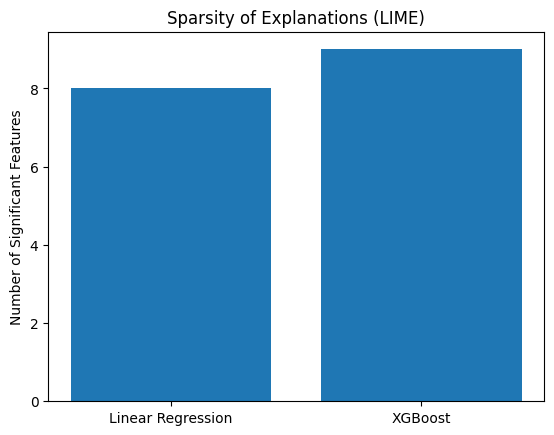

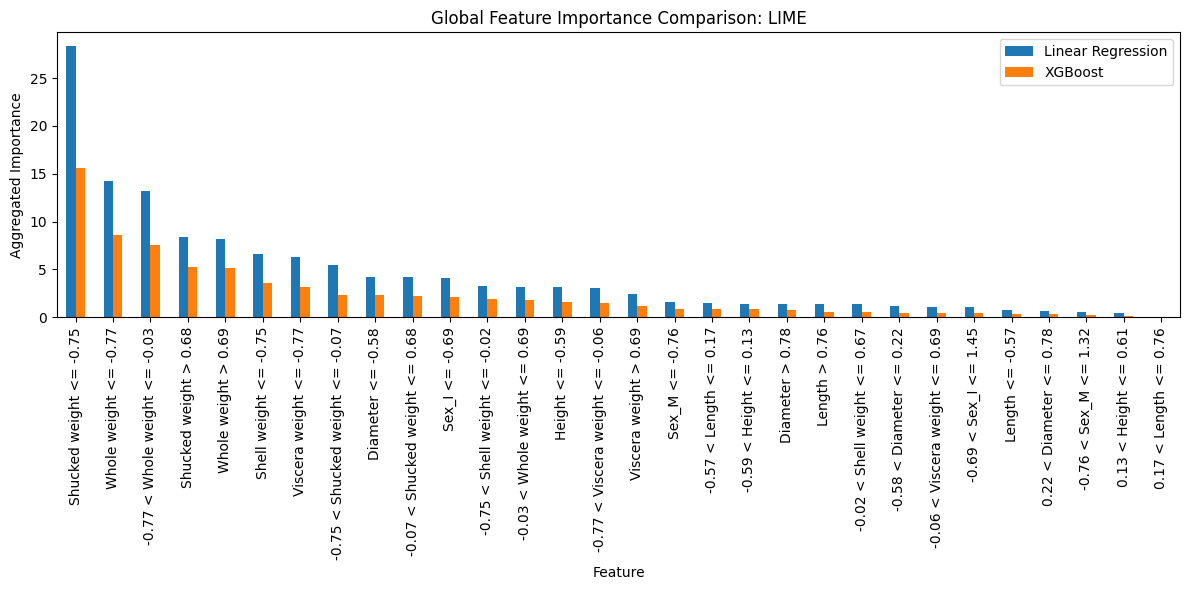


LIME analysis complete. Share the following outputs for further discussion:
- Fidelity errors for Linear Regression and XGBoost
- Stability comparison of original and perturbed explanations
- Sparsity (number of significant features)
- Global feature importance for both models


In [75]:
# -------------------------------
# Step 10: Visualize Results
# -------------------------------

# Sparsity Visualization
plt.bar(["Linear Regression", "XGBoost"], [sparsity_lr, sparsity_xgb])
plt.title("Sparsity of Explanations (LIME)")
plt.ylabel("Number of Significant Features")
plt.show()

# Global Feature Importance Comparison
global_importance_df = pd.DataFrame({
    "Feature": [x[0] for x in global_importance_lr],
    "Linear Regression": [x[1] for x in global_importance_lr],
    "XGBoost": [global_importance_xgb[i][1] if i < len(global_importance_xgb) else 0 
                for i in range(len(global_importance_lr))]
})

global_importance_df.set_index("Feature").plot(kind="bar", figsize=(12, 6))
plt.title("Global Feature Importance Comparison: LIME")
plt.ylabel("Aggregated Importance")
plt.xlabel("Feature")
plt.tight_layout()
plt.show()

print("\nLIME analysis complete. Share the following outputs for further discussion:")
print("- Fidelity errors for Linear Regression and XGBoost")
print("- Stability comparison of original and perturbed explanations")
print("- Sparsity (number of significant features)")
print("- Global feature importance for both models")

In [82]:

def compute_stability(original_explanation, perturbed_explanation):
    original_values = [v for _, v in original_explanation.as_list()]
    perturbed_values = [v for _, v in perturbed_explanation.as_list()]
    return mean_squared_error(original_values, perturbed_values)

# Example usage for Linear Regression
stability_error_lr = compute_stability(explanation_lr, perturbed_explanation_lr)
print(f"Stability Error for Linear Regression: {stability_error_lr:.4f}")

# Example usage for XGBoost
stability_error_xgb = compute_stability(explanation_xgb, perturbed_explanation_xgb)
print(f"Stability Error for XGBoost: {stability_error_xgb:.4f}")


Stability Error for Linear Regression: 3.9853
Stability Error for XGBoost: 0.0835
